<a href="https://colab.research.google.com/github/benihime91/retinanet_pet_detector/blob/master/notebooks/03_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**setup**

In [ ]:
# What GPU do we have ?
! nvidia-smi

Sun Sep  6 12:33:38 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Ensure colab doesn't disconnect
%%javascript
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}setInterval(ClickConnect,60000)

<IPython.core.display.Javascript object>

In [ ]:
# install dependencies
! pip install pytorch-lightning wandb --quiet
! pip install git+https://github.com/albumentations-team/albumentations --quiet

     |████████████████████████████████| 409kB 4.7MB/s 
     |████████████████████████████████| 1.4MB 14.9MB/s 
     |████████████████████████████████| 2.8MB 34.5MB/s 
     |████████████████████████████████| 829kB 44.4MB/s 
     |████████████████████████████████| 276kB 51.1MB/s 
     |████████████████████████████████| 163kB 56.1MB/s 
     |████████████████████████████████| 102kB 13.6MB/s 
     |████████████████████████████████| 102kB 13.3MB/s 
     |████████████████████████████████| 122kB 56.8MB/s 
     |████████████████████████████████| 71kB 10.7MB/s 
     |████████████████████████████████| 71kB 10.0MB/s 
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.2.0 which is incompatible.
     |████████████████████████████████| 952kB 4.6MB/s 


In [ ]:
# unzip the data assuming the `The Oxford-IIIT Pet Dataset` is present as /content/drive/My\ Drive/Data/oxford-iiit-pet.tgz
# to download the dataset go to this link:
# https://www.robots.ox.ac.uk/~vgg/data/pets/
!tar xf /content/drive/My\ Drive/Data/oxford-iiit-pet.tgz -C /content/ 

In [ ]:
# Clone the RetinaNet Repo:
! git clone https://github.com/benihime91/pytorch_retinanet.git

Cloning into 'pytorch_retinanet'...
remote: Enumerating objects: 109, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 1516 (delta 60), reused 56 (delta 22), pack-reused 1407
Receiving objects: 100% (1516/1516), 51.10 MiB | 27.95 MiB/s, done.
Resolving deltas: 100% (1011/1011), done.


In [ ]:
# use wandb to track experiments : Comment this if not using wandb logger
! wanbd login # a74f67fd5fae293e301ea8b6710ee0241f595a63

wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: a74f67fd5fae293e301ea8b6710ee0241f595a63
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


**required imports:**

In [ ]:
from typing import *
import pandas as pd
import os
import sys
import warnings
import numpy as np
import re
import time
import argparse

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    LearningRateLogger,
)

# Import some usefull utilities from the RetinaNet Repo
from pytorch_retinanet.src.models import Retinanet
from pytorch_retinanet.src.utils.eval_utils import CocoEvaluator
from pytorch_retinanet.src.utils.eval_utils import get_coco_api_from_dataset
from pytorch_retinanet.src.utils.general_utils import collate_fn, xml_to_csv
from pytorch_retinanet import DetectionDataset, Visualizer

pl.seed_everything(42) # change this seed number to get different results
pd.set_option("display.max_colwidth", None)
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Preprocess the data:** 

In [ ]:
annot_dir = '/content/oxford-iiit-pet/annotations/xmls' # folder where the annotations are stored
img_dir = '/content/oxford-iiit-pet/images' # folder where the training Images are stored

# Create pandas DataFrame from the xmls
df = xml_to_csv(annot_dir)
df.head(5)

filename  width  height class  xmin  ymin  xmax  ymax
0             Bengal_164.jpg    300     225   cat    89     1   291   151
1    wheaten_terrier_176.jpg    500     330   dog    84    30   236   188
2  British_Shorthair_178.jpg    500     336   cat   128    13   266   166
3          chihuahua_161.jpg    199     300   dog    79    27   174   146
4             Birman_168.jpg    500     333   cat    42    56   210   193

In [ ]:
# regex to extract the class names from the filenames of the csv file
pat = r"/([^/]+)_\d+.jpg$"
pat = re.compile(pat)


def get_classes(df=pd.DataFrame) -> pd.DataFrame:
    "creates labels for the Images from given filenames"
    # Extract the label
    df["class"] = [pat.search(fname).group(1).lower() for fname in df.filename]
    return df


def preprare_data(img_dir: str, data: Union[str, pd.DataFrame]) -> Union[pd.DataFrame, LabelEncoder]:
    "preprocess the given data and returns a pandas dataframe"
    if isinstance(data, str):
        df = pd.read_csv(data)
    else:
        df = data
    # modify filename to point to the image path
    df["filename"] = [os.path.join(img_dir, idx) for idx in df.filename.values]
    # get labels from the filename
    df = get_classes(df)
    # encode the labels: convert labels to integers
    le = LabelEncoder()
    int_cls = le.fit(df["class"].unique())
    df["labels"] = le.transform(df["class"])
    return df, le


def create_label_dict(dataframe: pd.DataFrame, encoder: LabelEncoder) -> Dict[int, str]:
    "Creates a label dictionary from the given dataframe `labels`"
    names = list(dataframe.labels.unique())
    names.sort()
    # Create the label dictionary
    label_dict = {idx: clas for idx, clas in zip(
        names, list(encoder.inverse_transform(names)))}
    return label_dict


In [ ]:
df , le = preprare_data(img_dir, df)
df.head()

filename  ...  labels
0             /content/oxford-iiit-pet/images/Bengal_164.jpg  ...       5
1    /content/oxford-iiit-pet/images/wheaten_terrier_176.jpg  ...      35
2  /content/oxford-iiit-pet/images/British_Shorthair_178.jpg  ...       9
3          /content/oxford-iiit-pet/images/chihuahua_161.jpg  ...      10
4             /content/oxford-iiit-pet/images/Birman_168.jpg  ...       6

[5 rows x 9 columns]

In [ ]:
# Grab the label dictionary
label_dict = create_label_dict(df, le)
label_dict

{0: 'abyssinian',
 1: 'american_bulldog',
 2: 'american_pit_bull_terrier',
 3: 'basset_hound',
 4: 'beagle',
 5: 'bengal',
 6: 'birman',
 7: 'bombay',
 8: 'boxer',
 9: 'british_shorthair',
 10: 'chihuahua',
 11: 'egyptian_mau',
 12: 'english_cocker_spaniel',
 13: 'english_setter',
 14: 'german_shorthaired',
 15: 'great_pyrenees',
 16: 'havanese',
 17: 'japanese_chin',
 18: 'keeshond',
 19: 'leonberger',
 20: 'maine_coon',
 21: 'miniature_pinscher',
 22: 'newfoundland',
 23: 'persian',
 24: 'pomeranian',
 25: 'pug',
 26: 'ragdoll',
 27: 'russian_blue',
 28: 'saint_bernard',
 29: 'samoyed',
 30: 'scottish_terrier',
 31: 'shiba_inu',
 32: 'siamese',
 33: 'sphynx',
 34: 'staffordshire_bull_terrier',
 35: 'wheaten_terrier',
 36: 'yorkshire_terrier'}

**utility function to display image with bounding boxes:**

In [ ]:
# Instantiate the visualizer
viz = Visualizer(class_names=label_dict)

# Function to display a random Image from the dataset
def display_random_image(dataframe: pd.DataFrame) -> None:
    "displays a radom Image from given dataframe"
    n = np.random.randint(0, len(dataframe))
    fname = df["filename"][n]
    boxes = df.loc[df["filename"] == fname][["xmin", "ymin", "xmax", "ymax"]].values
    labels = df.loc[df["filename"] == fname]["labels"].values
    viz.draw_bboxes(fname, boxes=boxes, classes=labels, figsize=(10, 10))

**Display image from the data:**

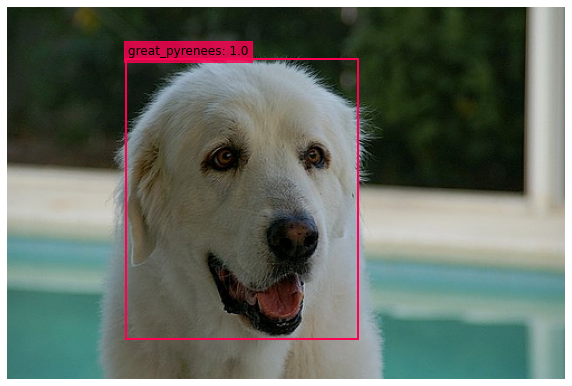

In [ ]:
# Display some random Images from the Dataset for sanity check
display_random_image(df)

In [ ]:
# Helper function to split a given DataFrame
def create_splits(df: pd.DataFrame, split_sz: float = 0.3) -> Tuple[pd.DataFrame, pd.DataFrame]:
    "Split given DataFrame into `split_sz`"
    
    # Grab the Unique Image Idxs from the Filename
    unique_ids = list(df.filename.unique())
    # Split the Unique Image Idxs into Train & valid Datasets
    train_ids, val_ids = train_test_split(
        unique_ids, shuffle=True, random_state=42, test_size=split_sz
    )

    # Create Splits on the DataFrame
    df["split"] = 0

    for i, idx in enumerate(df.filename.values):
        if idx in set(train_ids):
            df["split"][i] = "train"
        elif idx in set(val_ids):
            df["split"][i] = "val"

    # Split the DataFrame into Train and Valid DataFrames
    df_trn, df_val = df.loc[df["split"] ==
                            "train"], df.loc[df["split"] == "val"]
    df_trn, df_val = df_trn.reset_index(
        drop=True), df_val.reset_index(drop=True)

    # drop the extra redundent column
    df_trn.drop(columns=["split"], inplace=True)
    df_val.drop(columns=["split"], inplace=True)

    return df_trn, df_val

**Create spilts in the DataFrame to get `train`, `validation` & `test` sets**:

In [ ]:
# Create train and validation splits from the dataframe
df_trn, df_val = create_splits(df, split_sz=0.3)
df_val, df_test = create_splits(df_val, split_sz=0.5)

print('Num examples in train dataset :', len(df_trn.filename.unique()))
print('Num examples in train dataset :', len(df_val.filename.unique()))
print('Num examples in train dataset :', len(df_test.filename.unique()))

Num examples in train dataset : 2580
Num examples in train dataset : 553
Num examples in train dataset : 553


In [ ]:
# Peek at the train dataset for sanity check
df_trn.head(3)

filename  ...  labels
0    /content/oxford-iiit-pet/images/wheaten_terrier_176.jpg  ...      35
1  /content/oxford-iiit-pet/images/British_Shorthair_178.jpg  ...       9
2          /content/oxford-iiit-pet/images/chihuahua_161.jpg  ...      10

[3 rows x 9 columns]

In [ ]:
# Peek at the validation dataset for sanity check
df_val.head(3)

filename  width  ...  ymax labels
0        /content/oxford-iiit-pet/images/Sphynx_200.jpg    375  ...   254     33
1       /content/oxford-iiit-pet/images/Persian_101.jpg    377  ...   248     23
2  /content/oxford-iiit-pet/images/newfoundland_182.jpg    500  ...   287     22

[3 rows x 9 columns]

In [ ]:
df_test.head(3)

filename  ...  labels
0                     /content/oxford-iiit-pet/images/Bengal_164.jpg  ...       5
1     /content/oxford-iiit-pet/images/english_cocker_spaniel_123.jpg  ...      12
2  /content/oxford-iiit-pet/images/american_pit_bull_terrier_118.jpg  ...       2

[3 rows x 9 columns]

**sanity check**:

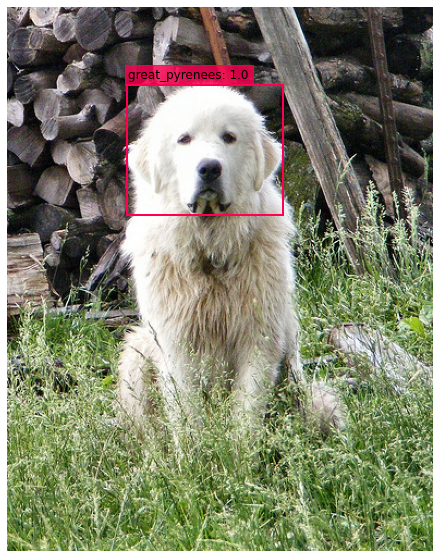

In [ ]:
# display random image from the train, valid 
# & test datasets for sanity check
display_random_image(dataframe=df_trn)

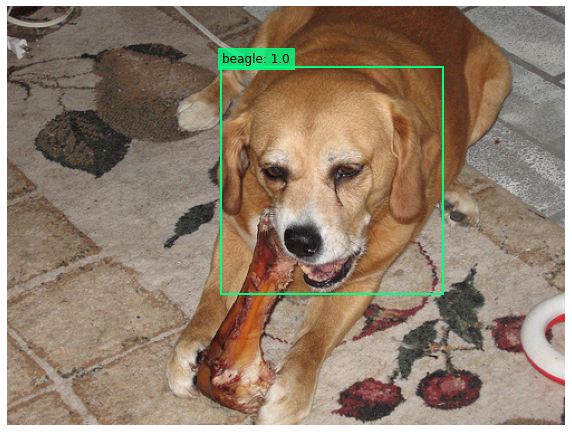

In [ ]:
display_random_image(dataframe=df_val)

In [ ]:
display_random_image(dataframe=df_test)

**Instantiate image transformations:**

We use `albumentations` for image transformations. Check [albumentations docs](https://albumentations.ai/docs/examples/example_bboxes/) for API reference & list of transformations

In [ ]:
def get_tfms() -> Dict[str, A.Compose]:
    "Returns a dictionary contatining transformations for train & valid/test datasets"
    # train transformations : [Modify this to add Transformations to train dataset]
    train_transformations = [
        A.HorizontalFlip(p=0.5),
        A.ToGray(p=0.2),
        A.RandomBrightnessContrast(),
        A.CLAHE(),
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True),
    ]

    # validation transformations : [Transformations to the validation & test dataset]
    valid_transformations = [
        A.ToFloat(max_value=255.0, always_apply=True),
        ToTensorV2(always_apply=True),
    ]

    # transforms dictionary :
    transforms = {
        "train": A.Compose(
            train_transformations,
            p=1.0,
            bbox_params=A.BboxParams(
                format="pascal_voc", label_fields=["class_labels"]
            ),
        ),
        "valid": A.Compose(
            valid_transformations,
            p=1.0,
            bbox_params=A.BboxParams(
                format="pascal_voc", label_fields=["class_labels"]
            ),
        ),
    }
    return transforms

**Create `pl.LightningModule` instance :**

In [ ]:
# Create pl.LightningModule instance
class DetectionModel(pl.LightningModule):
    def __init__(self,model: nn.Module, hparams: argparse.Namespace) -> None:
        super(DetectionModel, self).__init__()
        self.model = model
        self.hparams = hparams

    @property
    def num_batches(self) -> List:
        return [len(self.hparams.train_dl), len(self.hparams.val_dl), len(self.hparams.test_dl)]

    ######## Configure Optimizer & Schedulers #############
    def configure_optimizers(self, *args, **kwargs):
        "instatiate optimizer & scheduler(s)" 
        # optimizer
        optimizer = self.hparams.optimizer
        # scheduler
        scheduler = self.hparams.scheduler
        return [optimizer], [scheduler]

    ############# Train ##############
    def train_dataloader(self, *args, **kwargs):
        return self.hparams.train_dl

    def forward(self, xb, *args, **kwargs):
        return self.model(xb)

    def training_step(self, batch, batch_idx, *args, **kwargs):
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        loss_dict = self.model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        return {"loss": losses, "log": loss_dict, "progress_bar": loss_dict}

    ############# Validation ##############
    def val_dataloader(self, *args, **kwargs):
        loader = self.hparams.val_dl
        coco = get_coco_api_from_dataset(loader.dataset)
        self.coco_evaluator = CocoEvaluator(coco, self.hparams.iou_types)
        return loader

    def validation_step(self, batch, batch_idx, *args, **kwargs):
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        outputs = self.model(images, targets)
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        self.coco_evaluator.update(res)
        return {}


    def validation_epoch_end(self, outputs, *args, **kwargs):
        self.coco_evaluator.accumulate()
        self.coco_evaluator.summarize()
        metric = self.coco_evaluator.coco_eval["bbox"].stats[0]
        metric = torch.as_tensor(metric)
        logs = {"COCO_mAP": metric}
        return {"COCO_mAP": metric, "log": logs, "progress_bar": logs,}
    
    ############# Test ##############
    def test_dataloader(self, *args, **kwargs):
        loader = self.hparams.test_dl
        coco = get_coco_api_from_dataset(loader.dataset)
        self.test_evaluator = CocoEvaluator(coco, self.hparams.iou_types)
        return loader

    def test_step(self, batch, batch_idx, *args, **kwargs):
        images, targets, _ = batch
        targets = [{k: v for k, v in t.items()} for t in targets]
        outputs = self.model(images, targets)
        res = {target["image_id"].item(): output for target, output in zip(targets, outputs)}
        self.test_evaluator.update(res)
        return {}
    
    def test_epoch_end(self, outputs, *args, **kwargs):
        self.test_evaluator.accumulate()
        self.test_evaluator.summarize()
        metric = self.test_evaluator.coco_eval["bbox"].stats[0]
        metric = torch.as_tensor(metric)
        logs = {"COCO_mAP": metric}
        return {"COCO_mAP": metric, "log": logs, "progress_bar": logs,}

**Some Helper Functions :**

In [ ]:
def get_dataloaders(
    trn_df: pd.DataFrame, # train dataframe
    val_df: pd.DataFrame, # valid dataframe
    test_df: pd.DataFrame, # test dataframe
    trn_tfms: A.Compose, # transformations to apply to the train dataset
    val_tfms: A.Compose, # transformations to apply to the valid and test dataset
    trn_bs: int, # train batch size
    val_bs: int, # batch size for validaiton and test datasets
    ) -> Tuple[DataLoader, DataLoader, DataLoader]:
    
    # Instatiate the Detections Datasets
    train_ds = DetectionDataset(trn_df, trn_tfms)
    val_ds = DetectionDataset(val_df, val_tfms)
    test_ds = DetectionDataset(test_df, val_tfms)
    
    # Instatiate the dataloaders
    train_dl = DataLoader(train_ds, batch_size=trn_bs,shuffle=True, collate_fn=collate_fn, pin_memory=True,)
    
    val_dl = DataLoader(val_ds, batch_size=val_bs, shuffle=False, collate_fn=collate_fn, pin_memory=False,)
    
    test_dl = DataLoader(test_ds, batch_size=val_bs, shuffle=False, collate_fn=collate_fn, pin_memory=False,)
    # return dataloaders
    return train_dl, val_dl, test_dl

In [ ]:
def get_model(
    lr: float, # Learning rate
    num_epochs: int,  # number of epochs to train for
    nc: int, # number if classes in the dataset
    df_train: pd.DataFrame, # train dataframe
    df_val: pd.DataFrame, # validation dataframe
    df_test: pd.DataFrame, # test dataframe
    trn_tfms: A.Compose, # transformations to apply to the train dataset
    val_tfms: A.Compose, # transformations to apply to the valid and test dataset
    trn_bs: int, # train batch_size
    val_bs: int, # validation batch_size
    bkb: str, # retinanet backbone [currently supports only resnet models]
    **kwargs # retinanet model sepcific kwargs
) -> pl.LightningModule:

    """
    Creates lightning Module instance from given arguments.

    Returns:
        1. pl_model (pl.LightningModule)  : a pl.LightningModule instance
        2. dataloaders (List[Dataloader]) : list of train, val, test dataloaders
        3. hparams ([argparse.Namespace]) : hyperparmeters
    """
    # Load in the DataLoaders
    train_dl, val_dl, test_dl = get_dataloaders(df_train, df_val, df_test, trn_tfms, val_tfms, trn_bs, val_bs)
    # Instantiate RetinaNet model
    model = Retinanet(num_classes=nc, backbone_kind=bkb, **kwargs)

    # instantiate optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(params, lr, weight_decay=1e-02)
    # instantiate scheduler
    scheduler = {
        "scheduler": optim.lr_scheduler.OneCycleLR(optimizer, lr, epochs=num_epochs, steps_per_epoch=len(train_dl)),
        "interval": "step",
        "frequency": 1,
        }

    # Create Config Dictionary:
    conf_dict = {
        "train_dl": train_dl,
        "val_dl": val_dl,
        "test_dl": test_dl,
        "iou_types": ["bbox"],
        "optimizer": optimizer,
        "scheduler": scheduler,
    }
    
    hparams = argparse.Namespace(**conf_dict)
    # Instantiate lightning module
    pl_model = DetectionModel(model, hparams)
    dataloaders = [train_dl, val_dl, test_dl] 
    
    return pl_model, dataloaders, hparams

In [ ]:
def get_trainer(fname: Union[str, None] = None, **kwargs) -> pl.Trainer:
    "Returns a pl.Trainer instance"
    if fname is None:
        fname = "/content/drive/My Drive/pascal_checkpoints" 
    os.makedirs(fname, exist_ok=True)

    # Wandb logger: assuming wandb is set-up [Optional]
    wb_name = f"{time.strftime('%d-%m-||-%I.%M.%S%-p')}" # change the run name here
    wb_p = "retinanet-oxford-pets" # change the project name here
    
    wb_logger = WandbLogger(name=wb_name, project=wb_p, anonymous="allow",)

    # Learning_rate logger to monitor learning_rate [Optional]
    lr_logger = LearningRateLogger(logging_interval="step")
    # checkpoint callback
    checkpoint_callback = ModelCheckpoint(fname, mode="max", monitor="COCO_mAP", save_top_k=1,)
    # early stopping callback
    early_stopping_callback = EarlyStopping(mode="max", monitor="COCO_mAP", patience=5,)

    # Trainer
    trainer = pl.Trainer(
        logger=[wb_logger],
        callbacks=[lr_logger],
        num_sanity_val_steps=0,
        benchmark=True,
        early_stop_callback=early_stopping_callback,
        checkpoint_callback=checkpoint_callback,
        terminate_on_nan=True,
        **kwargs,
    )

    return trainer

**set training parameters:**

In [ ]:
# ------------------------------- #
# Training Parameters :
# ------------------------------- #
TRAIN_BATCH_SIZE = 32 # Batch size for train dataset
VALID_BATCH_SIZE = 32 # batch size for valid & test dataset
LR = 1e-03 # learning_rate for Optimizer
NUM_EPOCHS = 30
NUM_CLASSES = 37  # Oxford-IIIT Pets Dataset has 37 classes

**grab the model & the trainer:**

In [ ]:
# Grab the transforms
transforms = get_tfms()
trn_tfms = transforms['train']
val_tfms = transforms['valid']

# Instantiate the model & trainer    
retinanet, dataloaders, conf_dict = get_model(
    LR,
    NUM_EPOCHS,
    NUM_CLASSES,
    df_trn,
    df_val,
    df_test,
    trn_tfms,
    val_tfms,
    trn_bs=TRAIN_BATCH_SIZE,
    val_bs=VALID_BATCH_SIZE,
    bkb="resnet18", # change this if want to use other resnet backbone
)

trainer = get_trainer(check_val_every_n_epoch=5, gpus=1, precision=16, gradient_clip_val=0.1, max_epochs=NUM_EPOCHS,)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


**Train model:**

In [ ]:
trainer.fit(retinanet)


  | Name  | Type      | Params
------------------------------------
0 | model | Retinanet | 20 M  


creating index...
index created!


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.09s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.267
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.751
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.063
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.268
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.275
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.350
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.11s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.165
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.477
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.011
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.166
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.231
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.394
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.394
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.391
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.772
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.250
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.393
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.362
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.06s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.265
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.834
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.115
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.273
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.206
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.444
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.444
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.424
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.847
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.511
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.425
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.531
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.448
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.852
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.532
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.457
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

Saving latest checkpoint..


1

**Evaluate:**

In [ ]:
# Test model on the Test DataLoader
# NB: Best weights are automatically loaded
trainer.test()

creating index...
index created!


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.938
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.312
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.413
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.406
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.463
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.463
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

[{'COCO_mAP': 0.43353960396039604}]

**save trained weights**

In [ ]:
fname = '/content/drive/My Drive/resnet18-pets-ver0.0.1.pth'
torch.save(retinanet.model.state_dict(), fname, _use_new_zipfile_serialization=False)

**Finetune:**

**set-up finetune parameters:**

In [ ]:
# Set up new Parameters
LR = 1e-05
NUM_EPOCHS = 22

retinanet.model.requires_grad_(True)
params = [p for p in retinanet.model.parameters() if p.requires_grad]
# Instantiate Optimizer
optimizer = optim.AdamW(params, weight_decay=1e-02)

# instantiate scheduler
scheduler = {
    "scheduler": optim.lr_scheduler.OneCycleLR(optimizer, LR, epochs=NUM_EPOCHS, steps_per_epoch=len(conf_dict.train_dl)),
    "interval": "step",
    "frequency": 1,
    }


In [ ]:
# Change the parameters of the conf_dict
conf_dict.optimizer = optimizer
conf_dict.scheduler = scheduler

In [ ]:
# TODO: make it more effective

# Reinstantiate model
retinanet_2 = DetectionModel(retinanet.model, conf_dict)
retinanet_2.model.load_state_dict(torch.load(fname))

# Reinstantiate trainer
trainer_2 = get_trainer(check_val_every_n_epoch=5, gpus=1, precision=16, gradient_clip_val=0.1, max_epochs=NUM_EPOCHS,)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]
Using native 16bit precision.


**Train**:

In [ ]:
trainer_2.fit(retinanet_2)


  | Name  | Type      | Params
------------------------------------
0 | model | Retinanet | 20 M  


creating index...
index created!


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.03s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.433
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.855
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.407
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.442
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.381
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.537
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.04s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.443
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.855
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.532
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.452
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.512
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.512
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.859
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.434
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.494
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.494
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.431
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.855
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.500
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.431
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.419
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.487
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.487
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=

Saving latest checkpoint..


1

**Evaluate on test data**:

In [ ]:
trainer_2.test()

creating index...
index created!


Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.02s).
Accumulating evaluation results...
DONE (t=0.05s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.434
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.938
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.375
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.421
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.369
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.500
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=m

[{'COCO_mAP': 0.43353960396039604}]

**Inference**: 

**Load in a `torch` model to do inference:**

In [ ]:
# Instantiate Torch Model for Inference
m = Retinanet(num_classes=37, backbone_kind='resnet18')

# Load in the pretrained model weights
m.load_state_dict(torch.load(fname))

<All keys matched successfully>

**import & helper functions for inference:**

In [ ]:
from google.colab import files
from torchvision.ops.boxes import batched_nms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
test_tfms = A.Compose([A.ToFloat(max_value=255.0, always_apply=True), ToTensorV2(always_apply=True),])

In [ ]:
@torch.no_grad()
def get_preds(
    model: Union[nn.Module, pl.LightningModule],
    path: str,
    threshold: float,
    iou_threshold: float,
    device: torch.device,
) -> Tuple[List, List, List]:
    "Get predictions on image"
    
    model.to(device)

    # Load the imag
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    # Process the image
    img = test_tfms(image=img)["image"]
    img = img.to(device)
    # Generate predictions
    model.eval()
    pred = model([img])

    # Gather the bbox, scores & labels from the preds
    pred_boxes = pred[0]["boxes"]  # Bounding boxes
    pred_class = pred[0]["labels"]  # predicted class labels
    pred_score = pred[0]["scores"]  # predicted scores
    # Get list of index with score greater than threshold.
    mask = pred_score > threshold
    # Filter predictions
    boxes = pred_boxes[mask]
    clas = pred_class[mask]
    scores = pred_score[mask]

    # do NMS
    keep_idxs = batched_nms(boxes, scores, clas, iou_threshold)
    boxes = list(boxes[keep_idxs].cpu().numpy())
    clas = list(clas[keep_idxs].cpu().numpy())
    scores = list(scores[keep_idxs].cpu().numpy())
    return boxes, clas, scores


def object_detection_api(
    model: Union[nn.Module, pl.LightningModule],
    device: torch.device,
    img_path: str = None,
    score_threshold: float = 0.5,
    iou_threshold: float = 0.2,
) -> None:
    "Draw bbox predictions on given image at img_pth"
    if img_path is None:
        uploaded = files.upload()
        img_path = list(uploaded.keys())[0]
    print("[INFO] Generating predictions ....")
    bb, cls, sc = get_preds(model, img_path, score_threshold, iou_threshold, device,)
    print("[INFO] Creating bbox on the image .... ")
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    viz.draw_bboxes(img, boxes=bb, classes=cls, scores=sc)

**inference on test images:**

In [ ]:
idx = 10 # index of the test_image

object_detection_api(m, device=device, score_threshold=0.7, iou_threshold=0.2, img_path=df_test["filename"][idx],)

[INFO] Generating predictions ....
[INFO] Creating bbox on the image .... 


**inference on user given images:**

Saving British_Shorthair_141.jpg to British_Shorthair_141.jpg
[INFO] Generating predictions ....
[INFO] Creating bbox on the image .... 


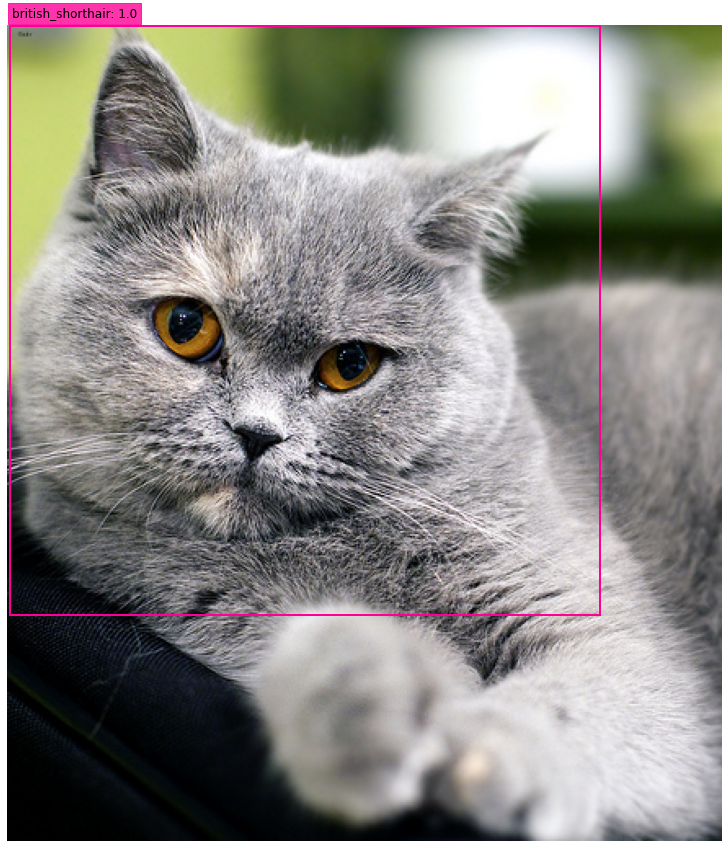

In [ ]:
# Inference on User Images
object_detection_api(m, device=device, score_threshold=0.7, iou_threshold=0.2,)